# Hospital Anomalies: Isolation Forest Baseline Model

This notebook demonstrates the baseline Isolation Forest anomaly detection model.

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent.parent.parent))

import pandas as pd
import matplotlib.pyplot as plt
from case_studies.hospital_anomalies.src.utils import load_config
from case_studies.hospital_anomalies.src.ingest import load_ingested_data
from case_studies.hospital_anomalies.src.features import engineer_features
from case_studies.hospital_anomalies.src.models.isolation_forest import IsolationForestDetector
from case_studies.hospital_anomalies.src.visualize import plot_time_series_with_anomalies

%matplotlib inline

## 1. Load Data and Configuration

In [2]:
config_path = Path.cwd().parent / 'config' / 'default.yaml'
config = load_config(config_path)
config_dict = config.to_dict()

datasets = load_ingested_data(config_dict['datasets'])
df = list(datasets.values())[0]  # Use first dataset

## 2. Feature Engineering

In [3]:
features_df = engineer_features(df, config_dict)
print(f"Engineered {len(features_df.columns)} features")
display(features_df.head())

Engineered 32 features


,date,region,hospital_id,admissions,year,month,day,day_of_week,day_of_year,quarter,...,admissions_rolling_max_14,admissions_rolling_mean_30,admissions_rolling_std_30,admissions_rolling_min_30,admissions_rolling_max_30,admissions_lag_1,admissions_lag_7,admissions_lag_30,admissions_diff_1,admissions_pct_change_1
0,2019-01-01,BC,H006,55,2019,1,1,1,1,1,...,55.0,55.000000,NaN,55.0,55.0,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,Alberta,H009,46,2019,1,2,2,2,1,...,55.0,50.500000,6.363961,46.0,55.0,55.0,NaN,NaN,-9.0,-0.163636
2,2019-01-03,Ontario,H002,57,2019,1,3,3,3,1,...,57.0,52.666667,5.859465,46.0,57.0,46.0,NaN,NaN,11.0,0.239130
3,2019-01-04,BC,H012,49,2019,1,4,4,4,1,...,57.0,51.750000,5.123475,46.0,57.0,57.0,NaN,NaN,-8.0,-0.140351
4,2019-01-05,BC,H003,52,2019,1,5,5,5,1,...,57.0,51.800000,4.438468,46.0,57.0,49.0,NaN,NaN,3.0,0.061224


## 3. Train Isolation Forest

In [4]:
# Select features
feature_cols = [
    col for col in features_df.columns
    if col not in ['date', 'region', 'hospital_id', 'year', 'month', 'day']
]
X = features_df[feature_cols].dropna()

# Train model
if_config = config_dict['isolation_forest']
detector = IsolationForestDetector(
    n_estimators=if_config['n_estimators'],
    contamination=if_config['contamination'],
    random_state=if_config['random_state']
)
detector.fit(X)

print(f"Model trained on {len(X)} samples")

Model trained on 1796 samples


## 4. Detect Anomalies

In [5]:
predictions = detector.get_anomalies(X)

print(f"Total anomalies: {predictions['is_anomaly'].sum()}")
print(f"Anomaly rate: {predictions['is_anomaly'].mean():.2%}")

Total anomalies: 90
Anomaly rate: 5.01%


## 5. Visualize Results

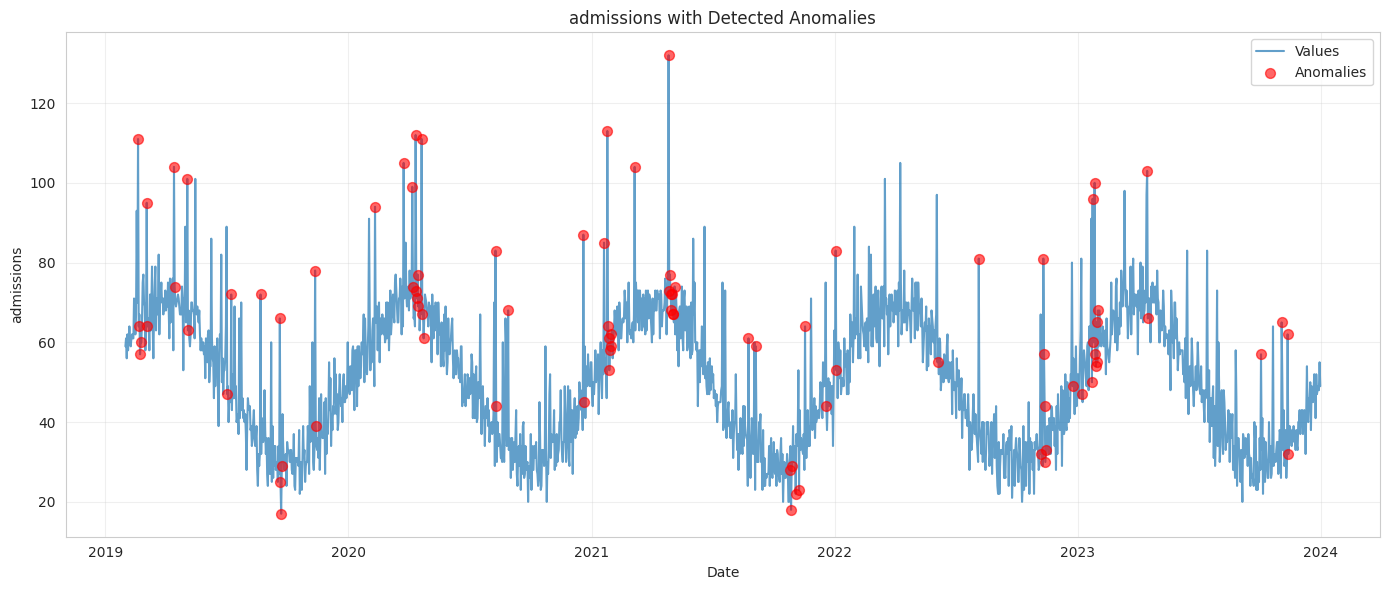

In [6]:
# Combine predictions with original data
results_df = features_df.loc[X.index].copy()
results_df['is_anomaly'] = predictions['is_anomaly']
results_df['anomaly_score'] = predictions['anomaly_score']

# Plot time series with anomalies
value_col = [c for c in df.columns if c not in ['date', 'region', 'hospital_id']][0]
if value_col in results_df.columns:
    plot_time_series_with_anomalies(
        results_df, 'date', value_col, 'is_anomaly',
        title=f'{value_col} with Detected Anomalies'
    )
    plt.show()

## 6. Top Anomalies

In [7]:
top_anomalies = results_df[results_df['is_anomaly']].nsmallest(10, 'anomaly_score')
display(top_anomalies[['date', value_col, 'anomaly_score']])

,date,admissions,anomaly_score
754,2021-01-24,113,-0.644100
846,2021-04-26,132,-0.636816
847,2021-04-27,73,-0.621445
755,2021-01-25,64,-0.613526
1409,2022-11-10,81,-0.610123
466,2020-04-11,112,-0.600087
1487,2023-01-27,57,-0.597022
467,2020-04-12,73,-0.593858
848,2021-04-28,77,-0.592692
476,2020-04-21,67,-0.589142
